Processing time step 40
Processing time step 30
Processing time step 20
Processing time step 10


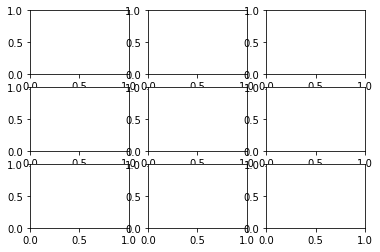

In [1]:
#!/usr/bin/python3
import numpy as np
import bisect as bi
from mpl_toolkits import mplot3d
import matplotlib.pyplot as pt
import control as ct
from control.matlab import *
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
pt.close()
fig, ax = pt.subplots(3,3)

# Helpers %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def edInt(a,s,b):
    return np.linspace(a,b,int(np.floor((b-a)/s)))

# Used for poorman's nearest-neighbour regular-grid interpolation
def idx(aList, val):
    i = bi.bisect(aList, val) # right
    if i <= 0: # first
        pass
    elif len(aList) == i: # last
        i -= 1
    elif val - aList[i-1] < aList[i] - val: # left
        i -= 1
    return i

def lookup(aList, vals):
    """result is undefined if vals is not sorted"""
    indices = []
    v = vals
    if type(v) in [int,float,np.int64,np.float64]:
        v = [v]
    for k in np.sort(v):
        indices.append(idx(aList,k))
    return np.array(indices, dtype=np.uint32)

# Settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
dt = .2; infStValInc = 300; nullCtr = 0; tf = 10
T = edInt(0, dt, tf) # time horizon
U = edInt(-60, 1, 60)  # admissible controls
x1, x2 = np.meshgrid(edInt(-10,2,110), edInt(-10,2,110)) # admissible states
a1 = a2 = .01
b1 = b2 = .005
A = np.array([[-a1, b1], [b2, -a2]])
B1 = np.array([1, 0])
B2 = np.array([0, 1])

# System constants
N = T.size
Q = np.array([[100, 0], [0, 100]])
R = 0.1
z0 = np.array([10, 0]) # initial state (only for simulation)
#w = np.array([50, 50]) # reference (or set-point)
w = np.zeros([N, 2]) # reference (or set-point)
w[:N//2,0] = 20
w[:N//2,1] = 20
w[N//2:,0] = 80
w[N//2:,1] = 80

ref_x1_traj = w[N-1,0]
ref_x2_traj = w[N-1,1]

erro_x1_end = x1 - ref_x1_traj
erro_x2_end = x2 - ref_x2_traj

custo_final = erro_x1_end**2 * Q[0,0] + erro_x2_end**2 * Q[1,1]

V1 = np.zeros((x2.shape[0], x1.shape[1], N))
V2 = np.zeros((x2.shape[0], x1.shape[1], N))

V1[:,:,N-1] = custo_final
V2[:,:,N-1] = custo_final


err_x1 = np.zeros((x2.shape[0], x1.shape[1]))
err_x2 = err_x1.copy()
depth=0 # for value snapshots

u_opt1 = np.zeros((x2.shape[0], x1.shape[1], N))
u_opt2 = np.zeros((x2.shape[0], x1.shape[1], N))
# Algorithm (operating on isolated equilibrium) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for k in range(N-1,depth,-1):
    ref_now = w[k]
    if (k%10)==0:
        print(f"Processing time step {k}")
    for i in range(0,x2.shape[0]):
        for j in range(0,x1.shape[1]):
            x_abs= np.array([x1[i,j], x2[i,j]])
            x_err = x_abs - ref_now # shifted state
            L = (x_err.T@Q@x_err).item() + R*U**2 # stage cost

            dx1_dt = A[0,0]*x_abs[0] + A[0,1]*x_abs[1] + B1[0]*U
            dx2_dt = A[1,0]*x_abs[0] + A[1,1]*x_abs[1] + B1[1]*U
            # dx1_dt = A[0,0]*x_err[0] + A[0,1]*x_err[1] + B1[0]*U
            # dx2_dt = A[1,0]*x_err[0] + A[1,1]*x_err[1] + B1[1]*U

            # forward Euler TANK 1
            x1_next_abs = x_abs[0] + dx1_dt * dt
            x2_next_abs = x_abs[1] + dx2_dt * dt  
            i_new_x1 = lookup(x1[0,:],x1_next_abs)      
            i_new_x2 = lookup(x2[:,0],x2_next_abs)

            i_U = range(0,U.size)
            err_x1[i,j] = np.max(x1_next_abs) # truncated dynamics
            err_x2[i,j] = np.max(x2_next_abs)
            
            #forward Euler TANK 2
            dx1_dt_2 = A[0,0]*x_abs[0] + A[0,1]*x_abs[1] + B2[0]*U
            dx2_dt_2 = A[1,0]*x_abs[0] + A[1,1]*x_abs[1] + B2[1]*U
            # dx1_dt_2 = A[0,0]*x_err[0] + A[0,1]*x_err[1] + B2[0]*U
            # dx2_dt_2 = A[1,0]*x_err[0] + A[1,1]*x_err[1] + B2[1]*U
            x1_next_abs_2 = x_abs[0] + dx1_dt_2 * dt
            x2_next_abs_2 = x_abs[1] + dx2_dt_2 * dt  
            i_new_x1_2 = lookup(x1[0,:],x1_next_abs_2)      
            i_new_x2_2 = lookup(x2[:,0],x2_next_abs_2)

            i_U_2 = range(0,U.size)
            err_x1[i,j] = np.max(x1_next_abs_2) # truncated dynamics
            err_x2[i,j] = np.max(x2_next_abs_2)
            # make sure admissible state/control exists TANK 1
            if (i_new_x1.size != 0 and i_new_x2.size != 0):
                V_next = V1[i_new_x2,i_new_x1,k]
                J_total = L + V_next
                i_U = np.argmin(J_total)
                V1[i,j,k-1] = J_total[i_U]
            else:
                i_U, V1[i,j,k-1] = lookup(U,nullCtr)[0][0], V1[i,j,k] + infStValInc
            u_opt1[i,j,k-1] = U[i_U] # i_U should be a singleton list

            # make sure admissible state/control exists TANK 2
            if (i_new_x1_2.size != 0 and i_new_x2_2.size != 0):
                V_next_2 = V2[i_new_x2_2,i_new_x1_2,k]
                J_total_2 = L + V_next_2
                i_U_2 = np.argmin(J_total_2)
                V2[i,j,k-1] = J_total_2[i_U_2]
            else:
                i_U_2, V2[i,j,k-1] = lookup(U,nullCtr)[0][0], V2[i,j,k] + infStValInc
            u_opt2[i,j,k-1] = U[i_U_2] # i_U should be a singleton list








In [2]:

pt.close('all') 
fig = pt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 3)

ax_x1 = fig.add_subplot(gs[0, 0])
ax_x2 = fig.add_subplot(gs[1, 0])
ax_u = fig.add_subplot(gs[2, 0])

# Simulation (from z0 using u_opt(x)) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
z = np.zeros((T.size,2))
z[0,:] = z0
u1 = np.zeros((T.size))
u2 = np.zeros((T.size))
current_mode = 1
High_lim = 5
Low_lim = 5

for k in range(0,T.size-1):
    if not(z[k,0] >= x1[0,0] and z[k,0] <= x1[0,-1] and z[k,1] >= x2[0,0] and z[k,1] <= x2[-1,0]): 
        print(f'Stopped at {k}/{T.size}: state {z[k,:]} out of grid bounds.')
        break
    i_idx = lookup(x2[:,0],z[k,1] )[0]
    j_jdx = lookup(x1[0,:],z[k,0])[0])
    u1[k] = u_opt1[i_idx, j_jdx, k]
    u2[k] = u_opt2[i_idx, j_jdx, k]
    reff_now = w[k]
    if current_mode == 1:
        z[k+1,:] = z[k,:] + dt*(A@ (z[k,:]) + B1 * u1[k])
        # JUMP TANK1 to TANK2
        if z[k+1,0] >=reff_now[0] + High_lim or z[k+1,1] <= reff_now[1] - Low_lim:
            current_mode = 2
    elif current_mode == 2:
        z[k+1,:] = z[k,:] + dt*(A@ (z[k,:]) + B2 * u2[k])
        # JUMP TANK2 to TANK1
        if z[k+1,0] <= reff_now[0] - Low_lim or z[k+1,1] >= reff_now[1] + High_lim:
            current_mode = 1



# Visualisation %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Vz0 = V1[lookup(x2[:,0],z0[1])[0], lookup(x1[0,:],z0[0])[0], 0]
inval_x1 = 100 * np.where(np.logical_or(err_x1[:,:] > x1[1,-1], err_x1[:,:] < x1[1,1]))[0].size \
    / (x1[:,1].size * x2[1,:].size)
inval_x2 = 100 * np.where(np.logical_or(err_x2[:,:] > x2[-1,1], err_x2[:,:] < x2[1,1]))[0].size \
    / (x1[:,1].size * x2[1,:].size)

ax_x1.plot(T, z[:,0], 'g-', linewidth=2, label=r'$x_1$ Real')
ax_x1.plot(T, w[:,0], 'r--', label=r'$x_1$ Ref')
ax_x1.set_ylabel(r'$x_1$ [Nivel]')
ax_x1.set_title('TANK 1')
ax_x1.grid(True, alpha=0.3)
ax_x1.legend(loc='upper left')

ax_x2.plot(T, z[:,1], 'b-', linewidth=2, label=r'$x_2$ Real')
ax_x2.plot(T, w[:,1], 'r--', label=r'$x_2$ Ref')
ax_x2.set_ylabel(r'$x_2$ [Nivel]')
ax_x2.set_title('TANK 2')
ax_x2.grid(True, alpha=0.3)
ax_x2.legend(loc='upper left')

ax_u.step(T, u1, 'g-', where='post', label=r'$u1$ (Mode 1)', alpha=0.7)
ax_u.step(T, u2, 'b-', where='post', label=r'$u2$ (Mode 2)', alpha=0.7)
ax_u.set_xlabel(r'Time [s]')
ax_u.set_ylabel(r'Input $u$')
ax_u.legend(loc='upper right')
ax_u.grid(True, alpha=0.3)

pt.tight_layout()
pt.show()

SyntaxError: unmatched ')' (626106985.py, line 23)